In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

print(tf.__version__)

Using TensorFlow backend.


1.13.1


In [2]:
base_skin_dir = os.path.join('', 'input')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
4318,HAM_0000824,ISIC_0029702,nv,follow_up,50.0,male,lower extremity,input/Ham10000_images_resize_part_1/ISIC_00297...,Melanocytic nevi,4
4365,HAM_0006298,ISIC_0030613,nv,follow_up,40.0,female,abdomen,input/Ham10000_images_resize_part_1/ISIC_00306...,Melanocytic nevi,4
815,HAM_0005610,ISIC_0027608,bkl,confocal,65.0,female,face,input/Ham10000_images_resize_part_1/ISIC_00276...,Benign keratosis-like lesions,2
9848,HAM_0002307,ISIC_0026549,akiec,histo,75.0,male,chest,input/Ham10000_images_resize_part_1/ISIC_00265...,Actinic keratoses,0
3577,HAM_0002997,ISIC_0029972,nv,follow_up,35.0,female,upper extremity,input/Ham10000_images_resize_part_1/ISIC_00299...,Melanocytic nevi,4
3059,HAM_0002112,ISIC_0030820,nv,follow_up,55.0,male,upper extremity,input/Ham10000_images_resize_part_1/ISIC_00308...,Melanocytic nevi,4
321,HAM_0007332,ISIC_0027780,bkl,histo,70.0,male,lower extremity,input/Ham10000_images_resize_part_1/ISIC_00277...,Benign keratosis-like lesions,2
1274,HAM_0006803,ISIC_0032400,mel,histo,60.0,female,abdomen,input/Ham10000_images_resize_part_1/ISIC_00324...,dermatofibroma,6
5879,HAM_0006402,ISIC_0025602,nv,follow_up,40.0,female,lower extremity,input/Ham10000_images_resize_part_1/ISIC_00256...,Melanocytic nevi,4
8466,HAM_0005051,ISIC_0031798,nv,histo,20.0,male,back,input/Ham10000_images_resize_part_1/ISIC_00317...,Melanocytic nevi,4


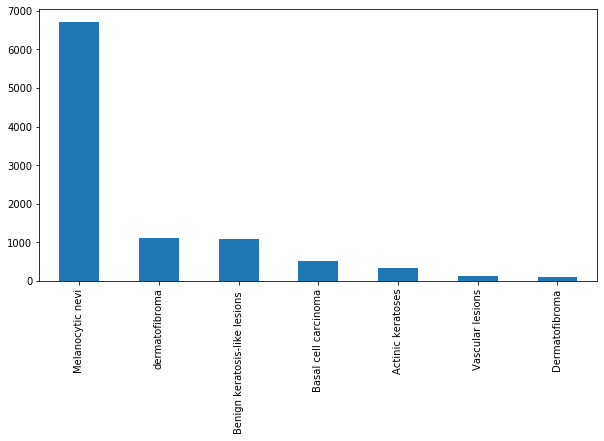

In [3]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

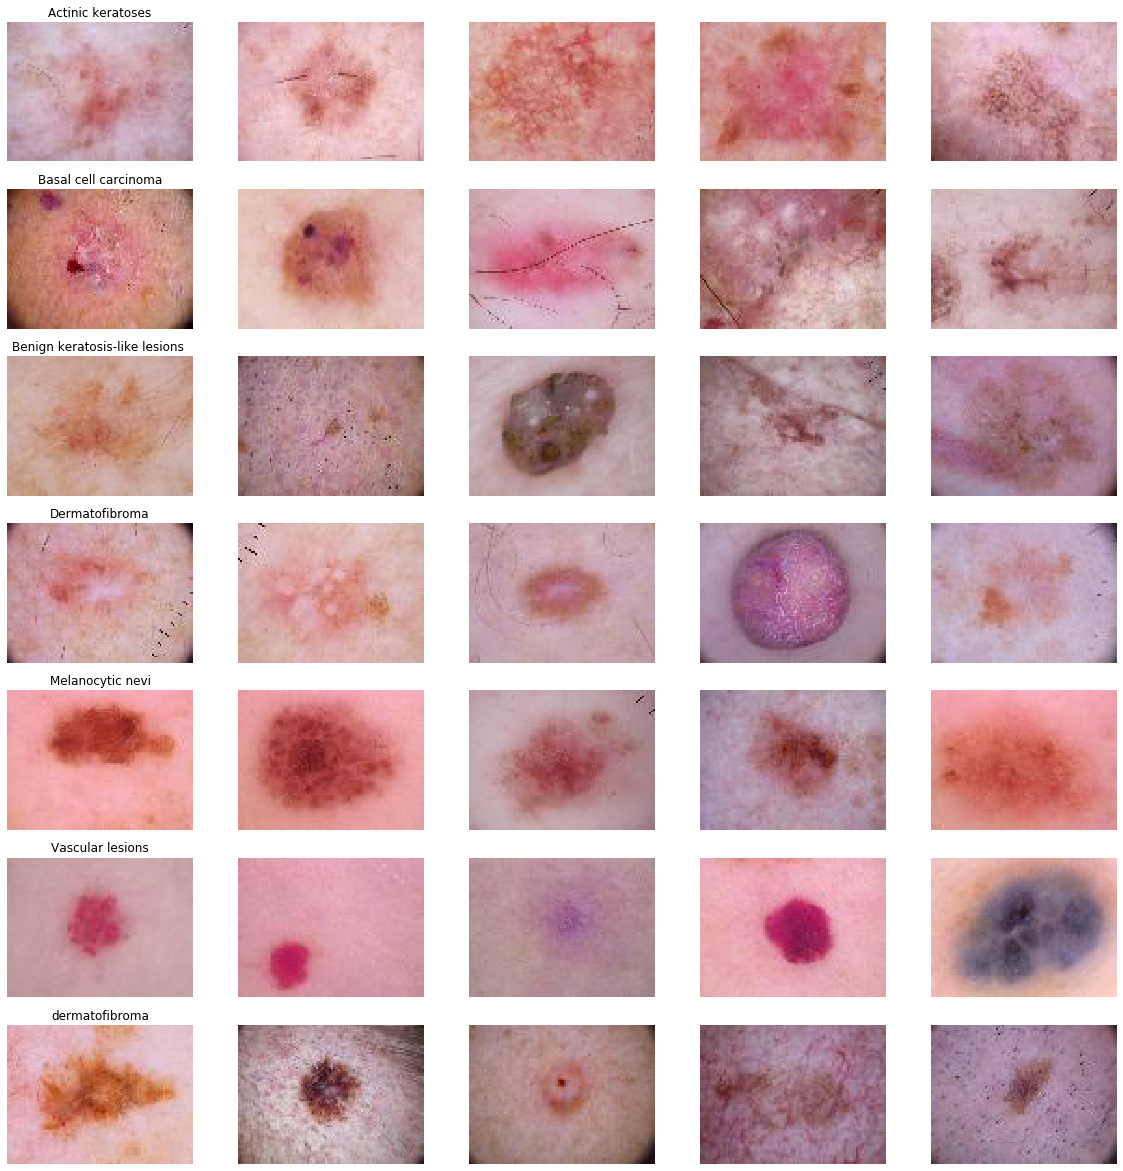

In [4]:
df['image'] = df['path'].map(imread)
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [5]:
#Selecting columns

#features = df['image']
features = df.drop(columns=['cell_type_idx'],axis=1)
target = df['cell_type_idx']

features.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
7081,HAM_0003951,ISIC_0024317,nv,histo,35.0,female,abdomen,input/Ham10000_images_resize_part_1/ISIC_00243...,Melanocytic nevi,"[[[215, 206, 227], [212, 203, 224], [209, 200,..."
9452,HAM_0005316,ISIC_0033907,nv,consensus,35.0,male,unknown,input/Ham10000_images_resize_part_1/ISIC_00339...,Melanocytic nevi,"[[[7, 5, 6], [7, 3, 4], [8, 2, 4], [13, 2, 8],..."
301,HAM_0005790,ISIC_0024672,bkl,histo,65.0,male,back,input/Ham10000_images_resize_part_1/ISIC_00246...,Benign keratosis-like lesions,"[[[161, 141, 142], [163, 143, 145], [160, 140,..."
4676,HAM_0002039,ISIC_0029663,nv,follow_up,50.0,female,trunk,input/Ham10000_images_resize_part_1/ISIC_00296...,Melanocytic nevi,"[[[229, 154, 148], [229, 154, 149], [229, 154,..."
4884,HAM_0002475,ISIC_0026685,nv,follow_up,70.0,female,foot,input/Ham10000_images_resize_part_1/ISIC_00266...,Melanocytic nevi,"[[[219, 144, 165], [221, 146, 167], [224, 149,..."


In [15]:
#Splitting data
x_training, x_test, y_training, y_test = train_test_split(features, target, test_size=0.20, random_state=1234)
x_train, x_validate, y_train, y_validate = train_test_split(x_training, y_training, test_size=0.20, random_state=42)

print(x_train.shape)
print(x_test.shape)
print(x_validate.shape)
print(y_train.shape)
print(y_test.shape)
print(y_validate.shape)

(6409, 10)
(2003, 10)
(1603, 10)
(6409,)
(2003,)
(1603,)


In [16]:
#convert data to array
X_train = np.asarray(x_train['image'].tolist())
X_validate = np.asarray(x_validate['image'].tolist())
X_test = np.asarray(x_test['image'].tolist())

In [17]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

In [18]:
#Encode target values
Y_train = to_categorical(y_train, num_classes=7)
Y_validate = to_categorical(y_validate, num_classes=7)
Y_test = to_categorical(y_test, num_classes=7)

#Y_train = y_train.values
#Y_validate = y_validate.values
#Y_test = y_test.values

print(Y_train.shape)
print(Y_validate.shape)
print(Y_test.shape)

(6409, 7)
(1603, 7)
(2003, 7)


In [19]:
#reshape data
print(X_train.shape)
# reshape dataset to have a single channel
width, height, channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]
X_train = X_train.reshape((X_train.shape[0], width, height, channels))
X_validate = X_validate.reshape((X_validate.shape[0], width, height, channels))
X_test = X_test.reshape((X_test.shape[0], width, height, channels))
print(X_train.shape)

(6409, 75, 100, 3)
(6409, 75, 100, 3)


In [20]:
#create generator to standardize images
datagen = ImageDataGenerator(featurewise_std_normalization=True)
#calculate mean and std on training dataset
datagen.fit(X_train)

In [21]:
#prepare an iterators to standardize images
train_iterator = datagen.flow(X_train, Y_train, batch_size = 64)
val_iterator = datagen.flow(X_validate, Y_validate, batch_size = 64)
test_iterator = datagen.flow(X_test, Y_test, batch_size = 64)

In [22]:
#build base model
first_model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, padding='Same', input_shape=(width, height, channels)),
    keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, padding='Same'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, padding='Same'),
    keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, padding='Same'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.40),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(7, activation=tf.nn.softmax)
])

first_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
first_history = first_model.fit_generator(
    train_iterator,
    steps_per_epoch=len(train_iterator),
    epochs = 20,
    validation_data=val_iterator,
    verbose=2
)
#print(y_train[0])

Epoch 1/20
26/26 [==============================] - 32s 1s/step - loss: 0.9624 - acc: 0.6706
 - 463s - loss: 1.1363 - acc: 0.6556 - val_loss: 0.9624 - val_acc: 0.6706
Epoch 2/20
26/26 [==============================] - 28s 1s/step - loss: 0.8504 - acc: 0.6762
 - 439s - loss: 0.9269 - acc: 0.6742 - val_loss: 0.8504 - val_acc: 0.6762
Epoch 3/20
26/26 [==============================] - 28s 1s/step - loss: 0.8850 - acc: 0.6781
 - 419s - loss: 0.8806 - acc: 0.6819 - val_loss: 0.8850 - val_acc: 0.6781
Epoch 4/20
26/26 [==============================] - 30s 1s/step - loss: 0.8081 - acc: 0.6875
 - 417s - loss: 0.8461 - acc: 0.6867 - val_loss: 0.8081 - val_acc: 0.6875
Epoch 5/20
26/26 [==============================] - 29s 1s/step - loss: 0.7904 - acc: 0.6974
 - 416s - loss: 0.8352 - acc: 0.6990 - val_loss: 0.7904 - val_acc: 0.6974
Epoch 6/20
26/26 [==============================] - 29s 1s/step - loss: 0.7723 - acc: 0.7093
 - 412s - loss: 0.7978 - acc: 0.7014 - val_loss: 0.7723 - val_acc: 0.709

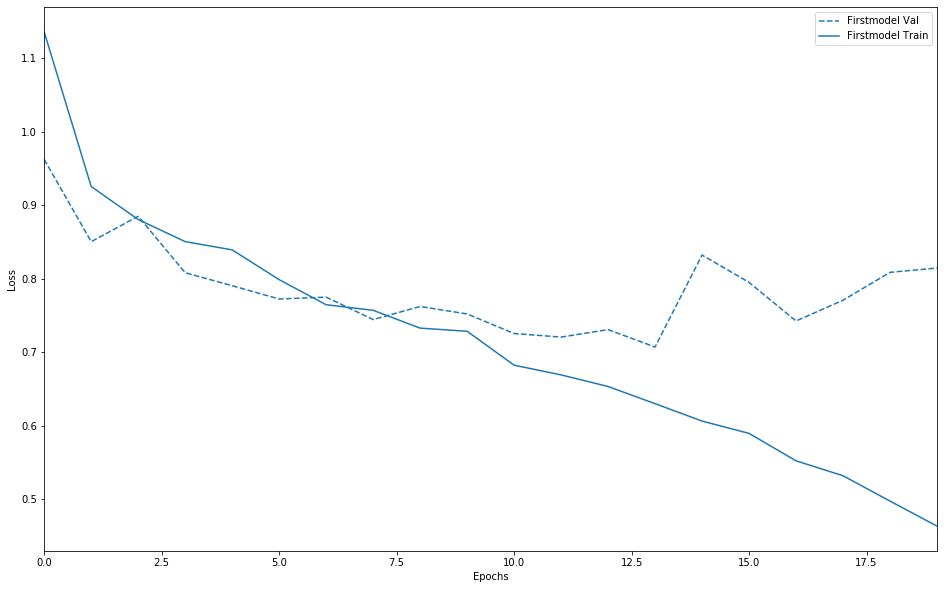

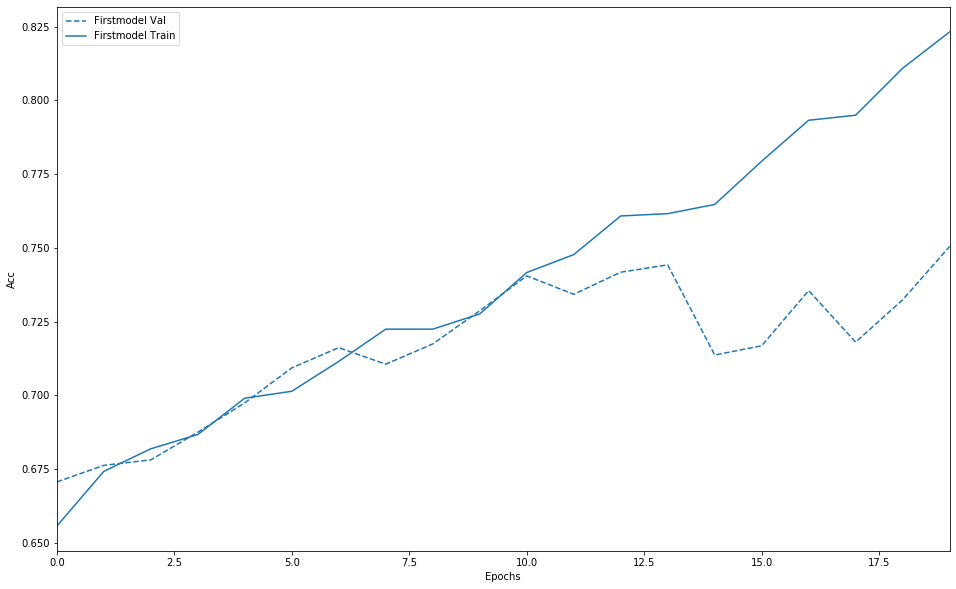

In [26]:
def plot_history(histories, key='acc', title="performance"):
    plt.figure(figsize=(16,10))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key], '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(), label=name.title()+' Train')
        
        plt.xlabel('Epochs')
        plt.ylabel(key.replace('-',' ').title())
        plt.legend()
        
        plt.xlim([0,max(history.epoch)])
        plt.savefig(title+'.png')
        
plot_history([('firstmodel', first_history),
             #('smaller', smaller_history),
             #('bigger', bigger_history),
             ], 
             key='loss', title="loss_function")

plot_history([('firstmodel', first_history),
             #('smaller', smaller_history),
             #('bigger', bigger_history),
             ], 
             key='acc', title="acc_function")

In [27]:
#from imblearn.over_sampling import ADASYN

loss, accuracy = first_model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)

print('Test accuracy: %.3f' %(accuracy*100))

Test accuracy: 73.640


In [39]:
import itertools

# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')

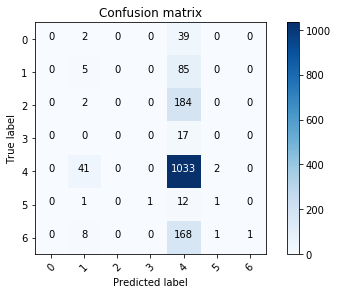

In [40]:
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset
Y_pred = first_model.predict(X_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

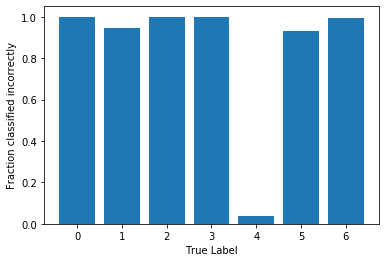

In [42]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.savefig('Fraction_classified_incorrectly.png')